In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/labels.txt
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/100932.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/12170.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/11355.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/145714.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/9015.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations/183142.xml
/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotat

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 21.1 MB/s eta 0:00:00


**Import all necassary packages**

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [4]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.0.0 (Tesla P100-PCIE-16GB)


In [5]:
images_path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/'

**YOLOv8 Model Training**

In [6]:
!pip install ultralytics

In [7]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 55.8MB/s]



image 1/1 /kaggle/input/image-for/crowded-places-in-india-kristian-bertel.jpg: 448x640 9 persons, 1 umbrella, 67.8ms
Speed: 9.6ms preprocess, 67.8ms inference, 20.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


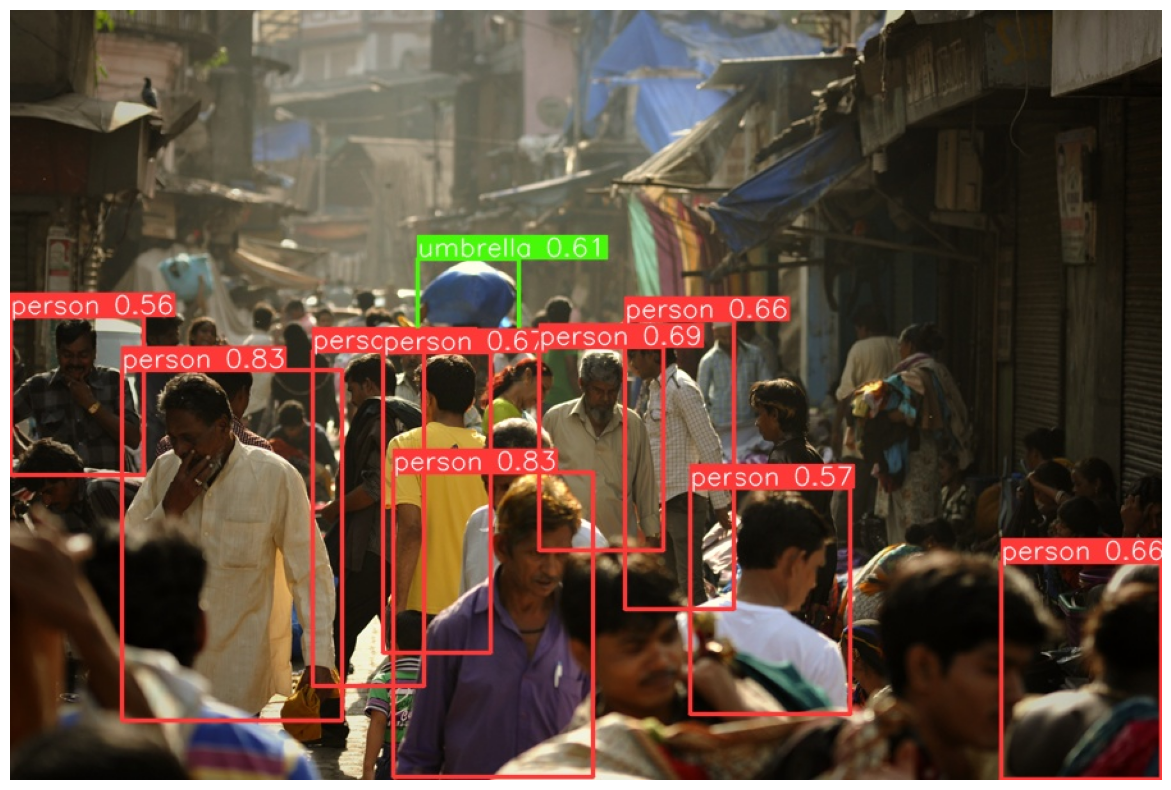

In [8]:
# choose random image
img = random.choice(os.listdir(images_path))

i=detection_model.predict(source='/kaggle/input/image-for/crowded-places-in-india-kristian-bertel.jpg',
                          conf=0.5, save=True, show_labels=True)

im = plt.imread('/kaggle/working/runs/detect/predict/crowded-places-in-india-kristian-bertel.jpg')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)

***The dataset contains already annotation files and images*...**


# **Training data with its annotations**

In [9]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])
            
            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)


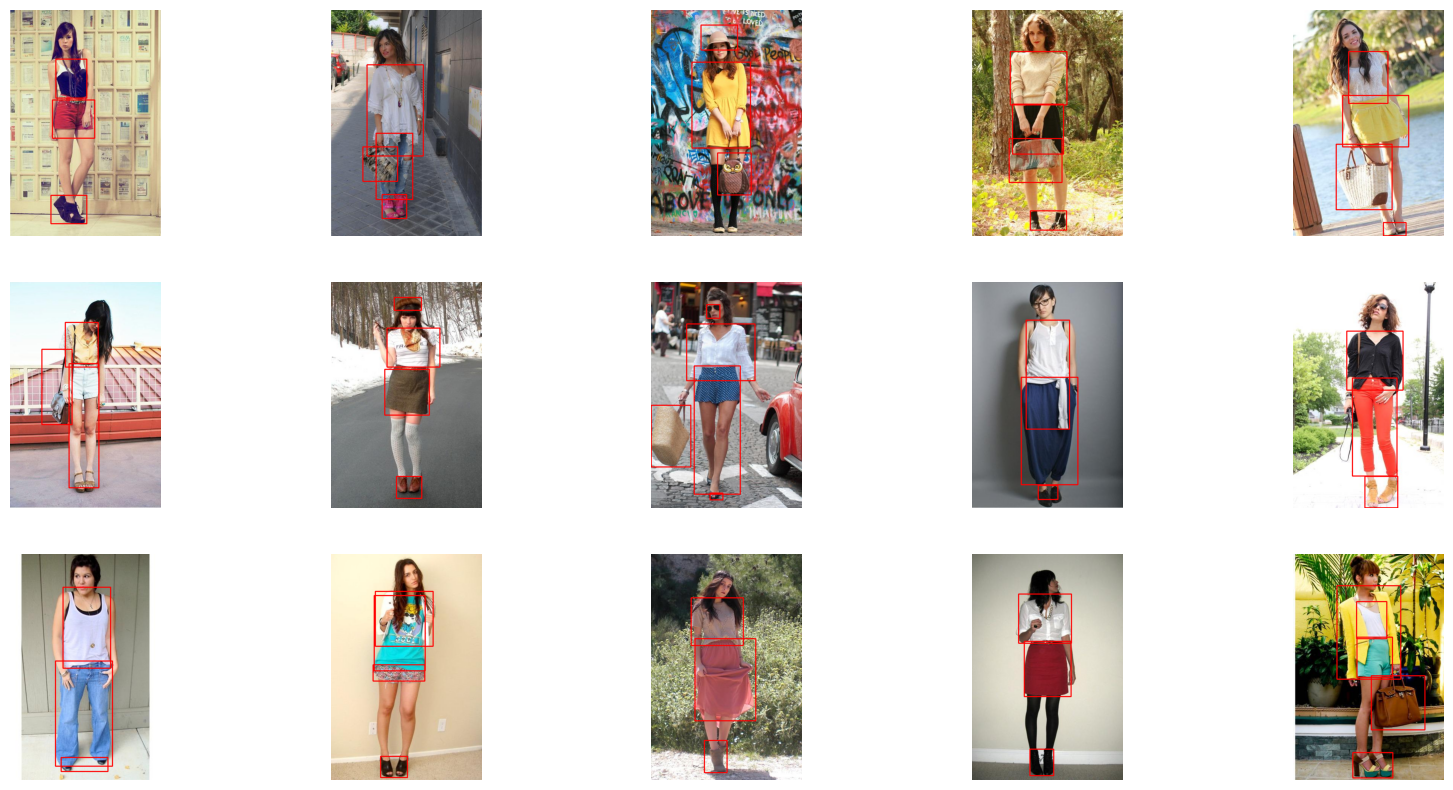

In [10]:
plt.figure(figsize=(20,10))
ls = os.listdir(images_path)
c = 1
for i in random.sample(ls, 15):
    img = plt.imread(images_path+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(3,5,c)
    plot_annotations(img, i)
    c+=1

In [11]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [12]:
len(train), len(test)

(2145, 537)

In [13]:
os.mkdir('train')
os.mkdir('train/images')
os.mkdir('train/labels')

os.mkdir('test')
os.mkdir('test/images')
os.mkdir('test/labels')

In [14]:
train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test/'

print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:29<00:00, 73.84it/s]


Copying Test Data..!!


100%|██████████| 537/537 [00:07<00:00, 71.32it/s]


**Train  Model**

In [15]:
text = """
train: /kaggle/working/train
val: /kaggle/working/test
#https://wandb.ai/home
# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)
model = YOLO("yolov8m.pt")

model.train(data='data.yaml', epochs=10)

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, 

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 137MB/s]
AMP: checks passed ✅
train: Scanning /kaggle/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 1606.63it/s]
train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 809.42it/s]
val: New cache created: /kaggle/working/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter g

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d620cc59900>
fitness: 0.5584187061697747
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.11877,      0.4529,     0.67382,     0.60262,     0.77547,     0.53454,     0.64011,     0.64055,     0.42988,     0.47001])
names: {0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants', 5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'}
plot: True
results_dict: {'metrics/precision(B)': 0.7812098651436109, 'metrics/recall(B)': 0.7582839914082207, 'metrics/mAP50(B)': 0.7794018746182785, 'metrics/mAP50-95(B)': 0.5338650207866076, 'fitness': 0.5584187061697747}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.6443077847500309, 'inference': 7.085678963687832, 'loss': 0.0008799

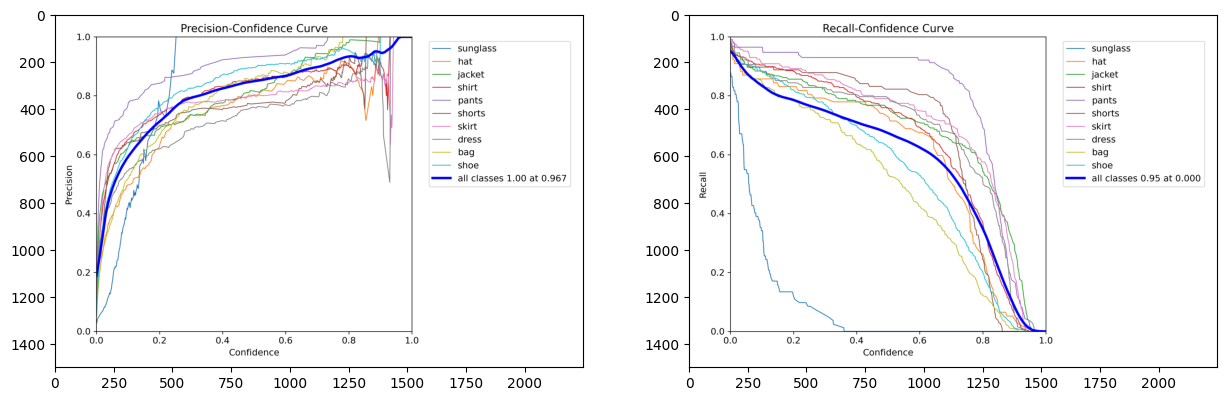

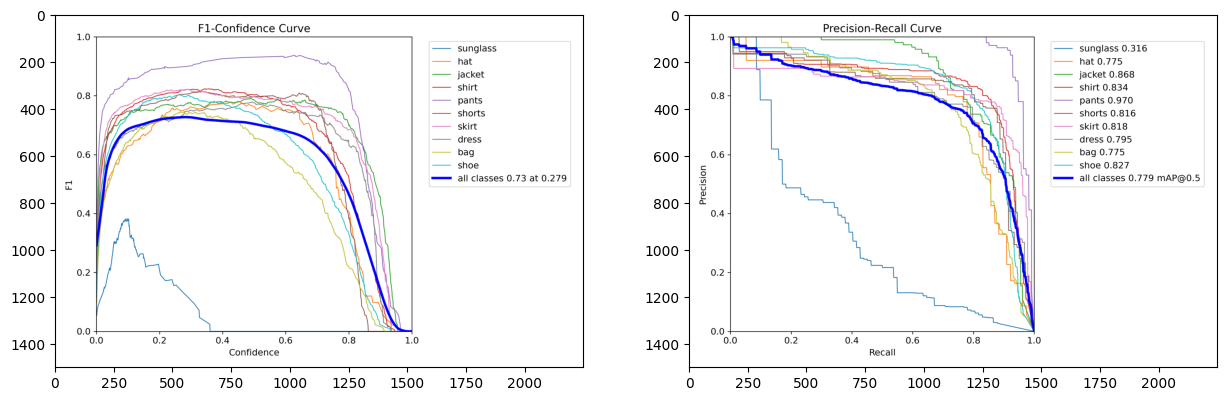

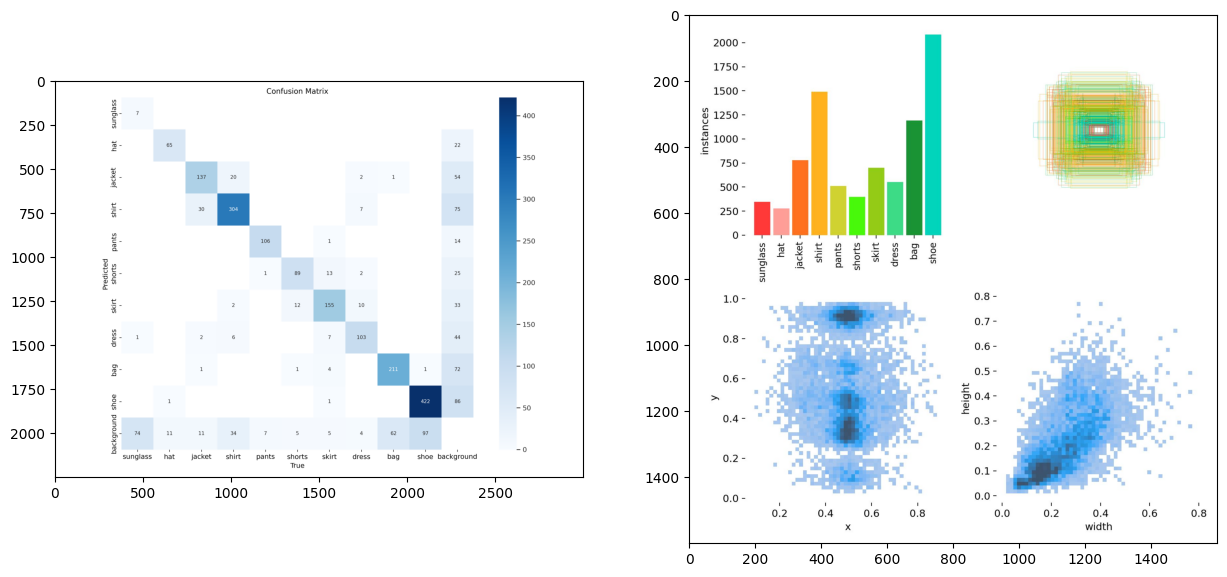

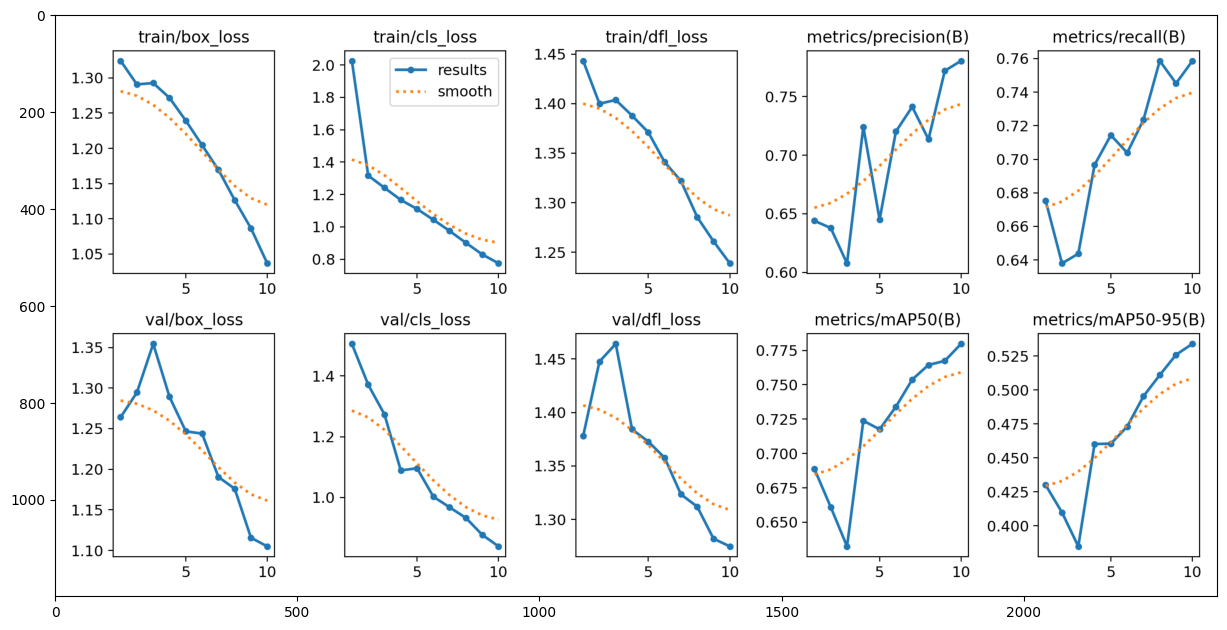

In [16]:
%matplotlib inline
model_path = 'runs/detect/train/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))



image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/190770.jpg: 640x448 1 shirt, 1 pants, 1 shoe, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict34

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/188841.jpg: 640x448 1 jacket, 1 shorts, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict35

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/53755.jpg: 640x448 1 shirt, 1 skirt, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict36

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-det

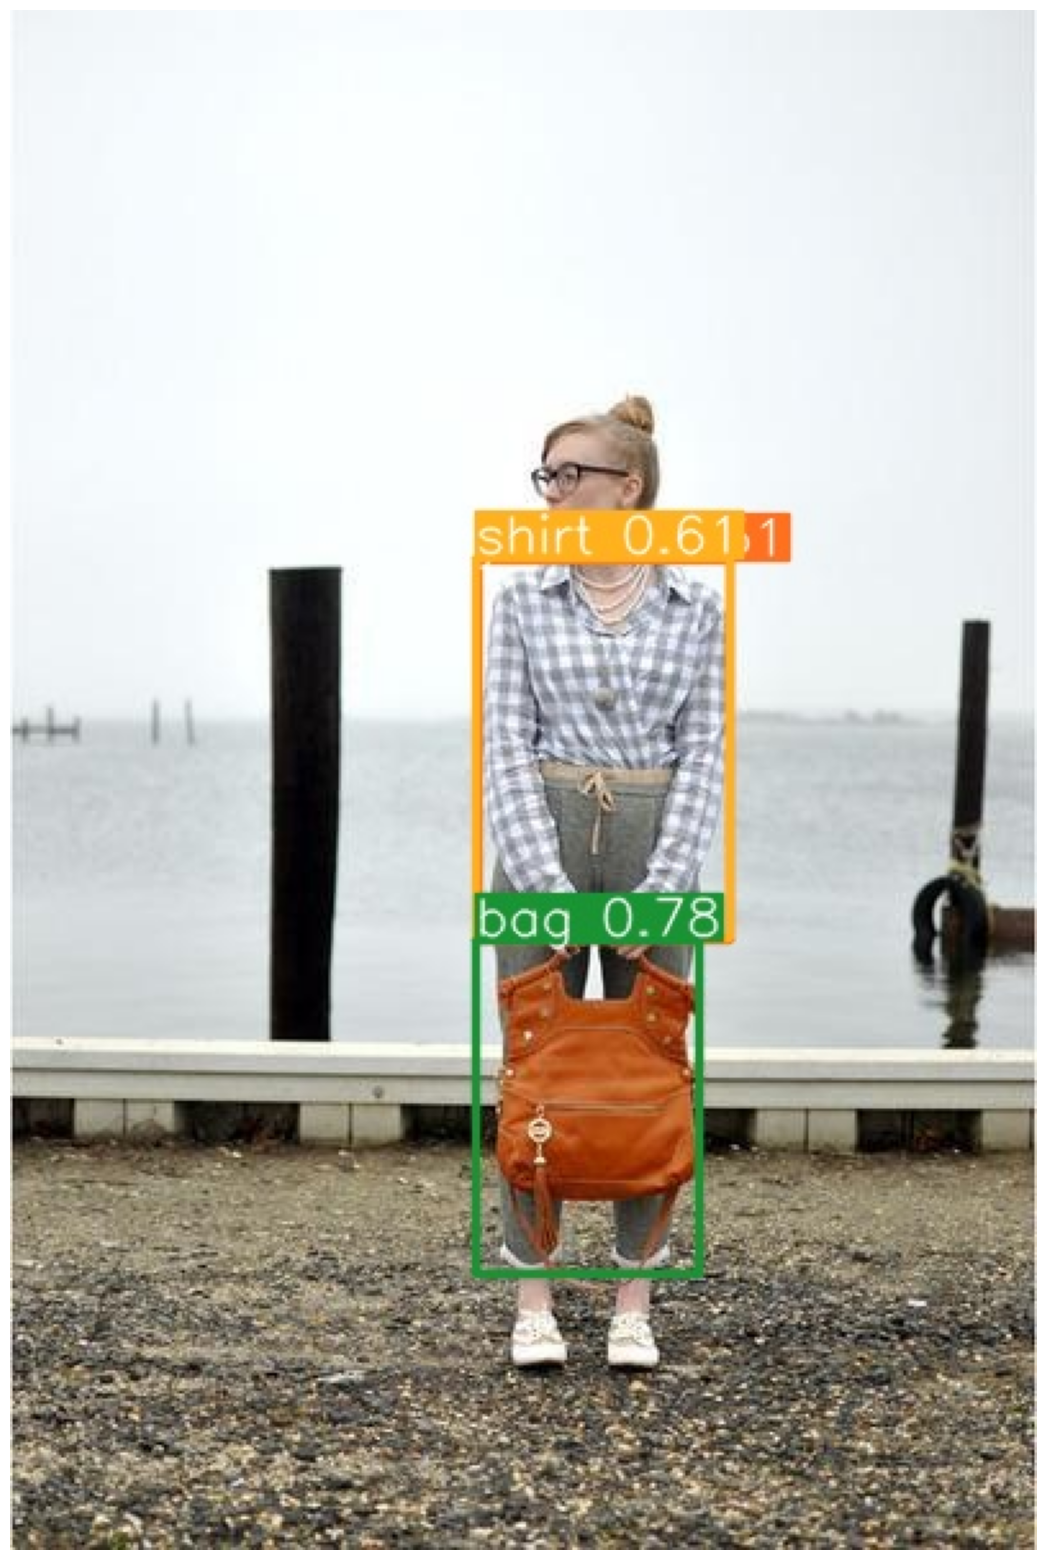

In [43]:
# choose random image from dataset
plt.figure(figsize=(20,20))
imgs = random.sample(os.listdir(images_path), 6)
c=1
for img in imgs:
    i=model.predict(source=images_path+img, conf=0.7, save=True)

    im = plt.imread('/kaggle/working/runs/detect/predict6/9267.jpg')
    plt.subplot(1,1,1)
    plt.axis('off')
    plt.imshow(im)
    c+=1


In [ ]:
i=detection_model.predict(source='/kaggle/input/fashion-test-images/fashion_test_images/34e73979b38a110a4acea3d5d995fd7b.jpg,
                          conf=0.5, save=True, show_labels=True)
